<a href="https://colab.research.google.com/github/gowri703/comparison_of_ml_vs_dl_of_pneumonia-detection-and-severity-analysis/blob/main/finalnomoreediting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


STAGE 0: IMPORTS


In [ ]:
import os
import zipfile
import shutil
import cv2
import numpy as np
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report


STAGE 1: DATASET DOWNLOAD & SETUP

In [ ]:
def setup_environment():
    print("\n--- ENVIRONMENT SETUP ---")
    raw_path = "/content/chest_xray_raw"

    if os.path.exists(f"{raw_path}/chest_xray"):
        print("Dataset already exists.")
        return f"{raw_path}/chest_xray"

    print("Upload kaggle.json")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    if filename != "kaggle.json":
        os.rename(filename, "kaggle.json")

    os.system("mkdir -p ~/.kaggle")
    os.system("cp kaggle.json ~/.kaggle/")
    os.system("chmod 600 ~/.kaggle/kaggle.json")

    os.system("kaggle datasets download -d paultimothymooney/chest-xray-pneumonia")

    with zipfile.ZipFile("chest-xray-pneumonia.zip", "r") as zip_ref:
        zip_ref.extractall(raw_path)

    return f"{raw_path}/chest_xray"


dataset_dir = setup_environment()



--- ENVIRONMENT SETUP ---
Upload kaggle.json


Saving kaggle.json to kaggle.json


STAGE 2: IMAGE PREPROCESSING (CLAHE)

In [ ]:
def apply_clahe(image):
    image = image.astype("uint8")
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    return final.astype("float32") / 255.0


STAGE 3: DATA GENERATORS

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe,
    rotation_range=12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


STAGE 4: CNN AS FEATURE EXTRACTOR

In [ ]:
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze CNN
for layer in base_model.layers:
    layer.trainable = False

gap = GlobalAveragePooling2D()(base_model.output)

feature_extractor = Model(
    inputs=base_model.input,
    outputs=gap
)

print("DenseNet121 feature extractor ready.")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet121 feature extractor ready.


STAGE 5: FEATURE EXTRACTION

In [ ]:
def extract_features(generator, max_samples=None):
    features = []
    labels = []
    collected = 0

    for imgs, lbls in generator:
        feats = feature_extractor.predict(imgs, verbose=0)
        features.append(feats)
        labels.append(lbls)

        collected += len(imgs)
        if max_samples and collected >= max_samples:
            break

    return np.vstack(features), np.hstack(labels)


print("\nExtracting deep features...")

X_train, y_train = extract_features(train_gen, max_samples=3000)
X_val, y_val = extract_features(val_gen, max_samples=800)

print("Train:", X_train.shape)
print("Val:", X_val.shape)



Extracting deep features...
Train: (3008, 1024)
Val: (800, 1024)


STAGE 6: FEATURE SCALING

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


STAGE 7: TRAIN 5 NON-CNN ML MODELS

STAGE 7: TRAIN 5 NON-CNN ML MODELS+CV


Model: SVM
SVM CV F1-score: 0.9704 ± 0.0053
SVM Validation Accuracy: 0.9463
              precision    recall  f1-score   support

      NORMAL       0.89      0.96      0.92       268
   PNEUMONIA       0.98      0.94      0.96       532

    accuracy                           0.95       800
   macro avg       0.93      0.95      0.94       800
weighted avg       0.95      0.95      0.95       800



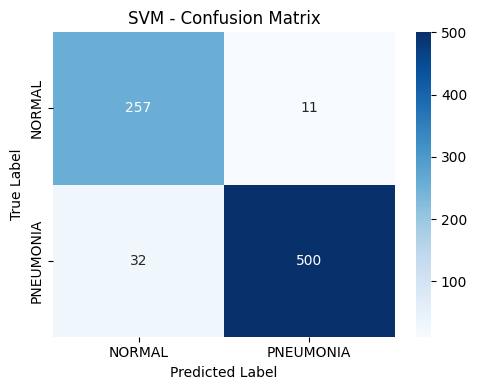


Model: Random Forest
Random Forest CV F1-score: 0.9538 ± 0.0069
Random Forest Validation Accuracy: 0.9237
              precision    recall  f1-score   support

      NORMAL       0.89      0.88      0.89       268
   PNEUMONIA       0.94      0.95      0.94       532

    accuracy                           0.92       800
   macro avg       0.92      0.91      0.91       800
weighted avg       0.92      0.92      0.92       800



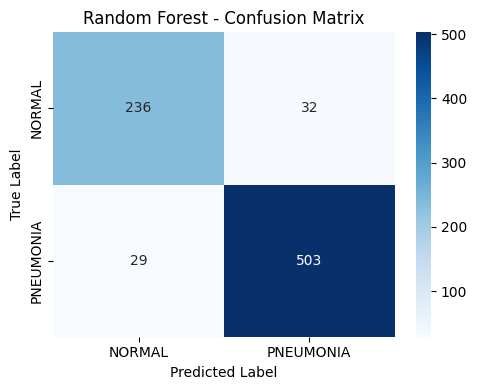


Model: Logistic Regression
Logistic Regression CV F1-score: 0.9708 ± 0.0017
Logistic Regression Validation Accuracy: 0.9550
              precision    recall  f1-score   support

      NORMAL       0.92      0.95      0.93       268
   PNEUMONIA       0.97      0.96      0.97       532

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.96      0.95      0.96       800



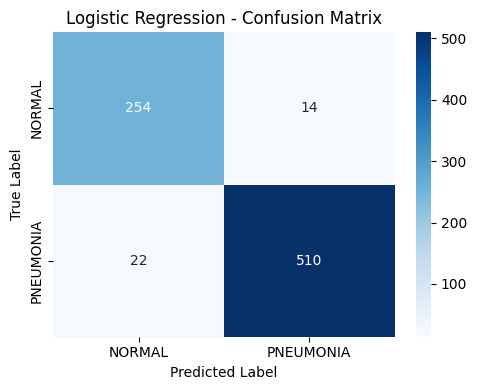


Model: KNN
KNN CV F1-score: 0.9470 ± 0.0069
KNN Validation Accuracy: 0.9025
              precision    recall  f1-score   support

      NORMAL       0.82      0.91      0.86       268
   PNEUMONIA       0.95      0.90      0.92       532

    accuracy                           0.90       800
   macro avg       0.89      0.90      0.89       800
weighted avg       0.91      0.90      0.90       800



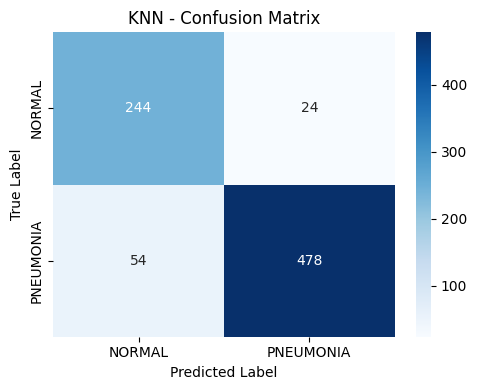


Model: Naive Bayes
Naive Bayes CV F1-score: 0.9202 ± 0.0073
Naive Bayes Validation Accuracy: 0.8762
              precision    recall  f1-score   support

      NORMAL       0.74      0.97      0.84       268
   PNEUMONIA       0.98      0.83      0.90       532

    accuracy                           0.88       800
   macro avg       0.86      0.90      0.87       800
weighted avg       0.90      0.88      0.88       800



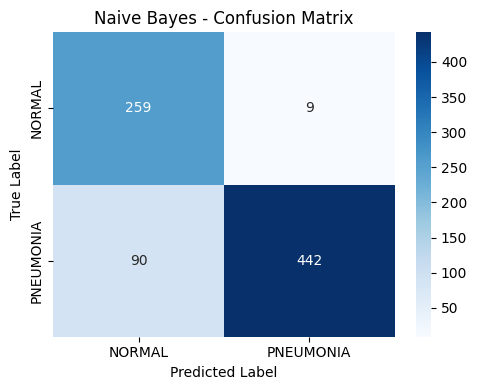


Final Validation Accuracy Comparison:
SVM: 0.9463
Random Forest: 0.9237
Logistic Regression: 0.9550
KNN: 0.9025
Naive Bayes: 0.8762


In [ ]:
# ===============================
# IMPORTS
# ===============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# ===============================
# MODEL DEFINITIONS
# ===============================
models = {
    "SVM": SVC(kernel="rbf", C=1.0, class_weight="balanced", random_state=42),

    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight="balanced",
        random_state=42
    ),

    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ),

    "KNN": KNeighborsClassifier(n_neighbors=5),

    "Naive Bayes": GaussianNB()
}

# ===============================
# CROSS-VALIDATION SETUP
# ===============================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

# ===============================
# TRAINING + EVALUATION LOOP
# ===============================
for name, model in models.items():
    print("\n" + "=" * 50)
    print(f"Model: {name}")
    print("=" * 50)

    # ---------------------------
    # CROSS-VALIDATION (ABLATION)
    # ---------------------------
    cv_f1_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=cv,
        scoring="f1"
    )

    print(
        f"{name} CV F1-score: "
        f"{cv_f1_scores.mean():.4f} ± {cv_f1_scores.std():.4f}"
    )

    # ---------------------------
    # TRAIN FINAL MODEL
    # ---------------------------
    model.fit(X_train_scaled, y_train)

    # ---------------------------
    # VALIDATION PREDICTIONS
    # ---------------------------
    preds = model.predict(X_val_scaled)

    acc = accuracy_score(y_val, preds)
    results[name] = acc

    print(f"{name} Validation Accuracy: {acc:.4f}")
    print(
        classification_report(
            y_val,
            preds,
            target_names=["NORMAL", "PNEUMONIA"]
        )
    )

    # ---------------------------
    # CONFUSION MATRIX
    # ---------------------------
    cm = confusion_matrix(y_val, preds)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["NORMAL", "PNEUMONIA"],
        yticklabels=["NORMAL", "PNEUMONIA"]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ===============================
# FINAL MODEL COMPARISON
# ===============================
print("\nFinal Validation Accuracy Comparison:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")


STAGE 8: MODEL COMPARISON SUMMARY

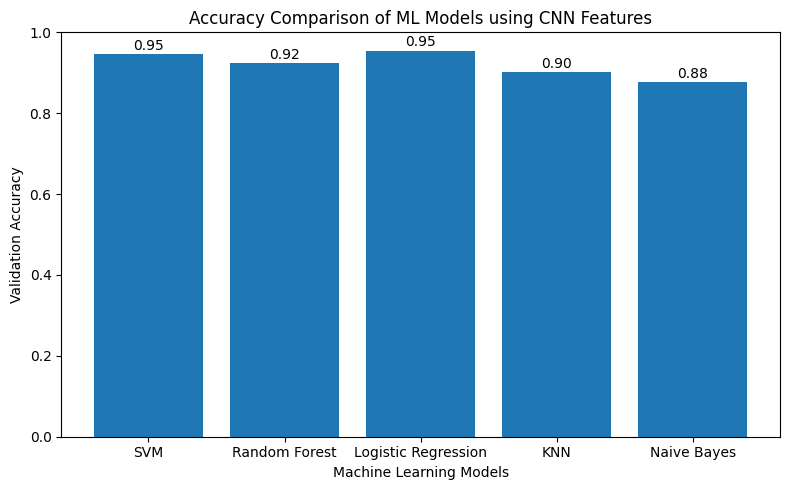

In [ ]:
import matplotlib.pyplot as plt

# Model names and accuracies
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies)
plt.ylim(0, 1)

plt.xlabel("Machine Learning Models")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy Comparison of ML Models using CNN Features")

# Show values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Run this first!
test_datagen = ImageDataGenerator(preprocessing_function=apply_clahe)

# Define the generator globally
test_
generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


CNN

with out hyperparameter (no fine tune)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.

Starting Fast Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8140 - loss: 0.3153 - val_accuracy: 0.7958 - val_loss: 0.4013
Epoch 2/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 821ms/step - accuracy: 0.9493 - loss: 0.1412 - val_accuracy: 0.9292 - val_loss: 0.1818
Epoch 3/8
27/60 ━━━━━━━━━━━━━━━━━━━━ 19s 579ms/step - accuracy: 0.9500 - loss: 0.1306

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 425ms/step - accuracy: 0.9514 - loss: 0.1297 - val_accuracy: 0.9458 - val_loss: 0.1488
Epoch 4/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 824ms/step - accuracy: 0.9534 - loss: 0.1127 - val_accuracy: 0.9417 - val_loss: 0.1531
Epoch 5/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 848ms/step - accuracy: 0.9545 - loss: 0.1096 - val_accuracy: 0.9479 - val_loss: 0.1308
Epoch 6/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 428ms/step - accuracy: 0.9667 - loss: 0.0804 - val_accuracy: 0.9500 - val_loss: 0.1192
Epoch 7/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 832ms/step - accuracy: 0.9624 - loss: 0.0887 - val_accuracy: 0.9563 - val_loss: 0.1173
Epoch 8/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 836ms/step - accuracy: 0.9664 - loss: 0.0891 - val_accuracy: 0.9396 - val_loss: 0.1475

--- EVALUATING ON TEST SET ---
Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 900ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.77      0.83     

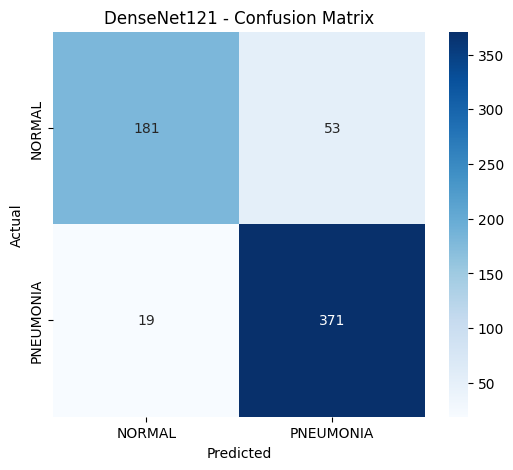


Exported 424 positive cases for Segmentation. Done!


In [ ]:
# ==========================================
# PART 3: OPTIMIZED DENSENET121 + EVALUATION
# ==========================================

import os
import zipfile
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. ENVIRONMENT SETUP ---
def setup_environment():
    raw_path = '/content/chest_xray_raw'
    if os.path.exists(f"{raw_path}/chest_xray"):
        return f"{raw_path}/chest_xray"

    print("Upload kaggle.json")
    uploaded = files.upload()
    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    shutil.copy(list(uploaded.keys())[0], os.path.expanduser('~/.kaggle/kaggle.json'))
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

    os.system('kaggle datasets download -d paultimothymooney/chest-xray-pneumonia')
    with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
        zip_ref.extractall(raw_path)
    return f"{raw_path}/chest_xray"

dataset_dir = setup_environment()

# --- 2. PREPROCESSING ---
def apply_clahe(image):
    img_uint8 = image.astype('uint8')
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2RGB).astype('float32') / 255.0

# --- 3. DATA GENERATORS ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(preprocessing_function=apply_clahe)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# --- 4. MODEL SETUP ---
base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# --- 5. TRAINING ---
weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(weights))

print("\nStarting Fast Training...")
model.fit(
    train_generator,
    steps_per_epoch=60,
    validation_data=val_generator,
    validation_steps=15,
    epochs=8,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

# --- 6. FINAL EVALUATION & CONFUSION MATRIX ---
print("\n--- EVALUATING ON TEST SET ---")
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Crucial for confusion matrix
)

# Get predictions
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = test_generator.classes

# 1. Print Text Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# 2. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('DenseNet121 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- 7. EXPORTING DETECTED CASES (FOR PART 4) ---
save_dir = '/content/detected_pneumonia_cases'
if os.path.exists(save_dir): shutil.rmtree(save_dir)
os.makedirs(save_dir)

# Using our already calculated y_pred to move files
filenames = test_generator.filenames
count = 0
for idx, pred_val in enumerate(y_pred):
    if pred_val == 1: # If predicted as Pneumonia
        shutil.copy(os.path.join(dataset_dir, 'test', filenames[idx]),
                    os.path.join(save_dir, os.path.basename(filenames[idx])))
        count += 1

print(f"\nExported {count} positive cases for Segmentation. Done!")

fine tunded

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.

Starting Stage 1: Initial Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8161 - loss: 0.3200 - val_accuracy: 0.9396 - val_loss: 0.1749
Epoch 2/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 816ms/step - accuracy: 0.9519 - loss: 0.1266 - val_accuracy: 0.9312 - val_loss: 0.1680
Epoch 3/8
27/60 ━━━━━━━━━━━━━━━━━━━━ 20s 623ms/step - accuracy: 0.9430 - loss: 0.1359

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 432ms/step - accuracy: 0.9419 - loss: 0.1363 - val_accuracy: 0.9521 - val_loss: 0.1517
Epoch 4/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 833ms/step - accuracy: 0.9654 - loss: 0.0960 - val_accuracy: 0.9333 - val_loss: 0.1557
Epoch 5/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 860ms/step - accuracy: 0.9460 - loss: 0.1351 - val_accuracy: 0.9646 - val_loss: 0.0927
Epoch 6/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 426ms/step - accuracy: 0.9620 - loss: 0.0963 - val_accuracy: 0.9625 - val_loss: 0.0884
Epoch 7/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 828ms/step - accuracy: 0.9694 - loss: 0.0828 - val_accuracy: 0.9375 - val_loss: 0.1497
Epoch 8/8
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 849ms/step - accuracy: 0.9692 - loss: 0.0832 - val_accuracy: 0.9500 - val_loss: 0.1293

Unfreezing top layers for Stage 2: Fine-Tuning...
Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9646 - loss: 0.0950 - val_accuracy: 0.9458 - val_loss: 0.1220
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.975

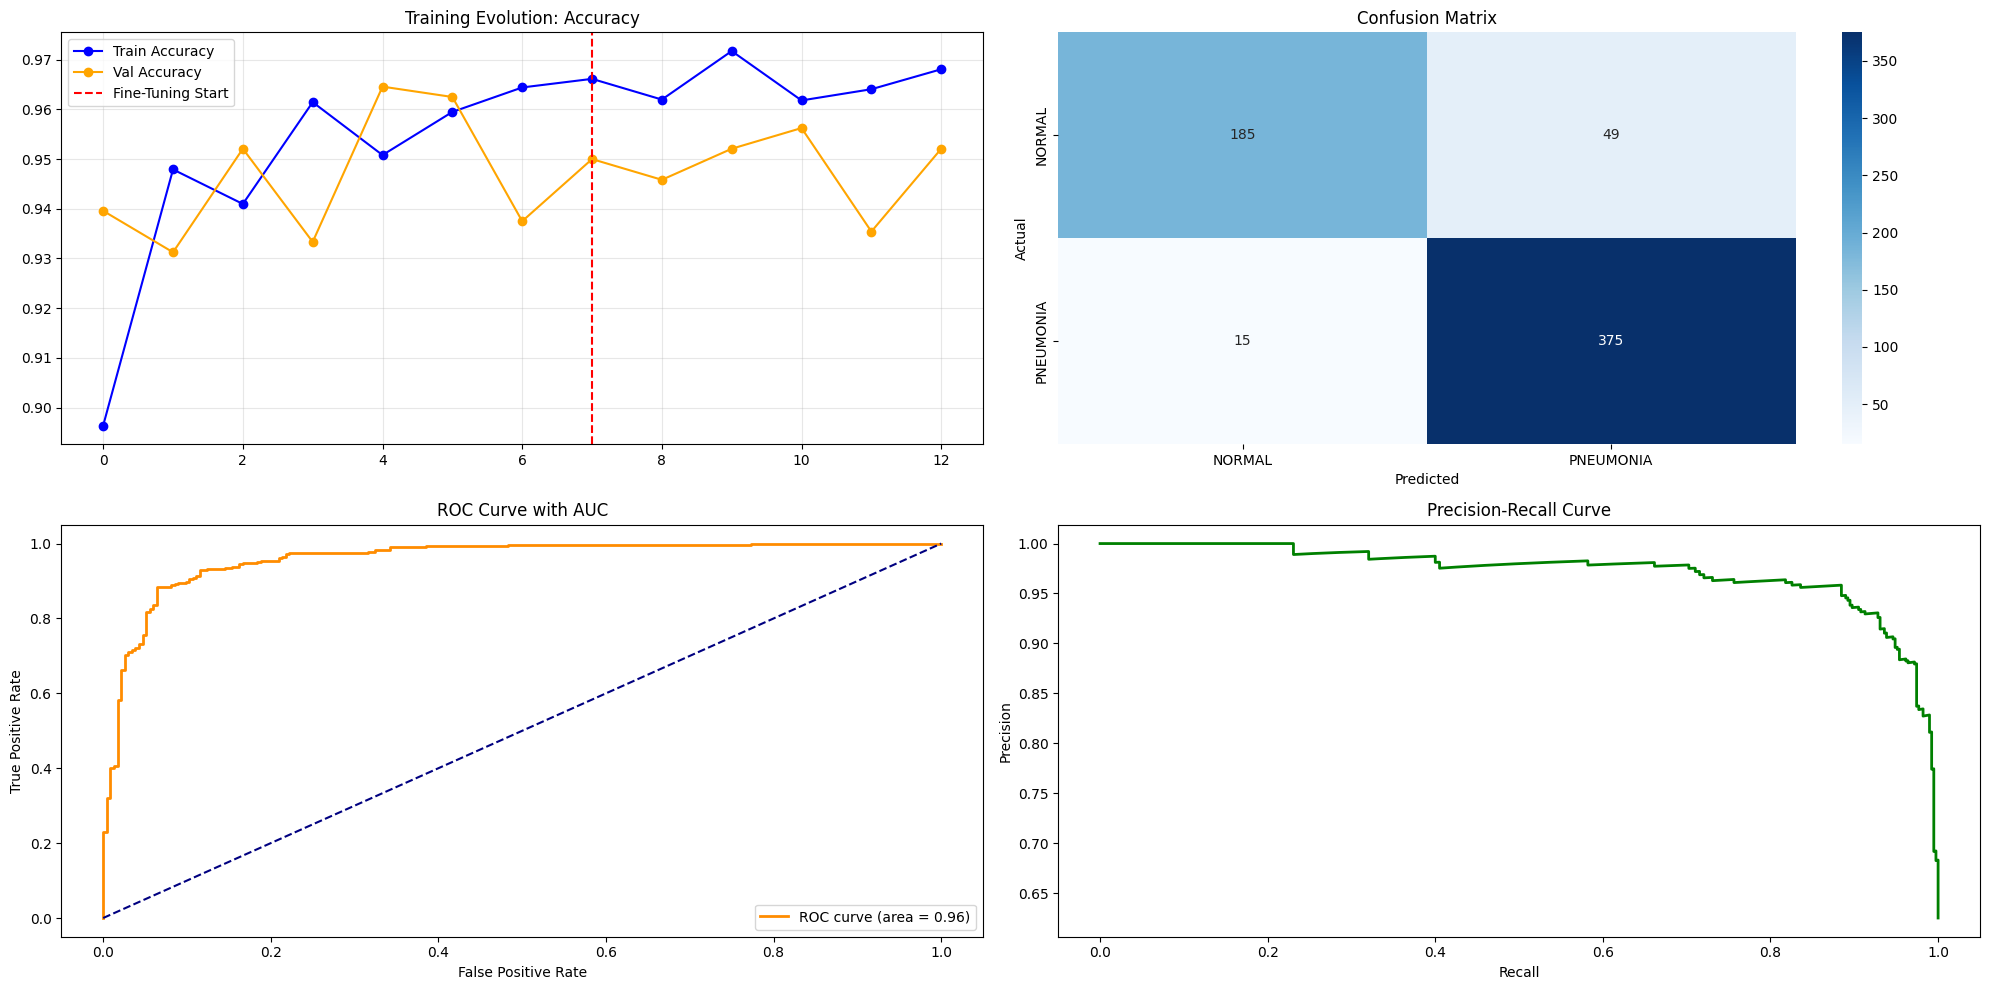


Exported 424 positive cases for Segmentation. Done!


In [ ]:
# ==========================================
# PART 3: OPTIMIZED DENSENET121 + EVALUATION
# ==========================================

import os
import zipfile
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. ENVIRONMENT SETUP ---
def setup_environment():
    raw_path = '/content/chest_xray_raw'
    if os.path.exists(f"{raw_path}/chest_xray"):
        return f"{raw_path}/chest_xray"

    print("Upload kaggle.json")
    uploaded = files.upload()
    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    shutil.copy(list(uploaded.keys())[0], os.path.expanduser('~/.kaggle/kaggle.json'))
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

    os.system('kaggle datasets download -d paultimothymooney/chest-xray-pneumonia')
    with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
        zip_ref.extractall(raw_path)
    return f"{raw_path}/chest_xray"

dataset_dir = setup_environment()

# --- 2. PREPROCESSING ---
def apply_clahe(image):
    img_uint8 = image.astype('uint8')
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2RGB).astype('float32') / 255.0

# --- 3. DATA GENERATORS ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(preprocessing_function=apply_clahe)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# --- 4. MODEL SETUP ---
base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# --- 5. TRAINING ---
weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(weights))

print("\nStarting Stage 1: Initial Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=60,
    validation_data=val_generator,
    validation_steps=15,
    epochs=8,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

# --- 5.1 FINE-TUNING STAGE ---
print("\nUnfreezing top layers for Stage 2: Fine-Tuning...")
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=60,
    validation_data=val_generator,
    validation_steps=15,
    epochs=5,
    class_weight=class_weights_dict
)

# --- 6. FINAL EVALUATION & VISUALIZATION ---
print("\n--- EVALUATING ON TEST SET ---")
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Get predictions
preds_prob = model.predict(test_generator)
y_pred = (preds_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# 2. Comprehensive Visualization Dashboard
def plot_dashboard(history, ft_history, y_true, y_probs):
    plt.figure(figsize=(20, 10))

    # A. Accuracy & Loss vs Epochs
    acc = history.history['accuracy'] + ft_history.history['accuracy']
    val_acc = history.history['val_accuracy'] + ft_history.history['val_accuracy']

    plt.subplot(2, 2, 1)
    plt.plot(acc, label='Train Accuracy', color='blue', marker='o')
    plt.plot(val_acc, label='Val Accuracy', color='orange', marker='o')
    plt.axvline(x=len(history.history['accuracy'])-1, color='red', linestyle='--', label='Fine-Tuning Start')
    plt.title('Training Evolution: Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # B. Confusion Matrix
    plt.subplot(2, 2, 2)
    cm = confusion_matrix(y_true, (y_probs > 0.5).astype(int))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # C. ROC Curve
    plt.subplot(2, 2, 3)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title('ROC Curve with AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    # D. Precision-Recall Curve
    plt.subplot(2, 2, 4)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.plot(recall, precision, color='green', lw=2)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.tight_layout()
    plt.show()

plot_dashboard(history, fine_tune_history, y_true, preds_prob)

# --- 7. EXPORTING DETECTED CASES ---
save_dir = '/content/detected_pneumonia_cases'
if os.path.exists(save_dir): shutil.rmtree(save_dir)
os.makedirs(save_dir)

filenames = test_generator.filenames
count = 0
for idx, pred_val in enumerate(y_pred):
    if pred_val == 1:
        shutil.copy(os.path.join(dataset_dir, 'test', filenames[idx]),
                    os.path.join(save_dir, os.path.basename(filenames[idx])))
        count += 1

print(f"\nExported {count} positive cases for Segmentation. Done!")

Example path: /content/test.jpg
Please paste the full path of the image: /content/test.jpg


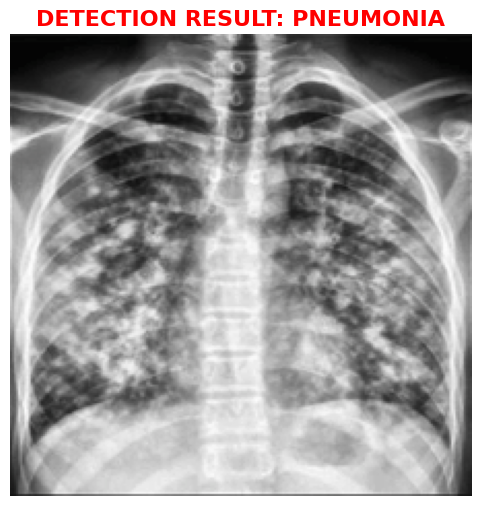

Analysis Complete. The system has identified this scan as: PNEUMONIA


In [ ]:
# ==========================================
# PART 3.8: LINK-BASED IMAGE PREDICTION
# ==========================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def predict_from_path(model):
    # 1. Input the image path (link)
    print("Example path: /content/test.jpg")
    img_path = input("Please paste the full path of the image: ").strip()

    # Verify if path exists
    if not os.path.exists(img_path):
        print(f"Error: Could not find image at {img_path}")
        return

    # 2. Load and Preprocess
    img = cv2.imread(img_path)
    if img is None:
        print("Error: Could not decode image.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to match DenseNet input (224, 224)
    img_resized = cv2.resize(img_rgb, (224, 224))

    # Apply your specific CLAHE preprocessing
    img_preprocessed = apply_clahe(img_resized)

    # Add batch dimension (1, 224, 224, 3)
    img_batch = np.expand_dims(img_preprocessed, axis=0)

    # 3. Make Prediction
    prediction = model.predict(img_batch, verbose=0)[0][0]

    # 4. Result Formatting
    # Based on your binary setup: 0 = NORMAL, 1 = PNEUMONIA
    label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    color = 'red' if label == "PNEUMONIA" else 'green'

    # 5. Display Result
    plt.figure(figsize=(6, 6))
    plt.imshow(img_preprocessed)
    plt.title(f"DETECTION RESULT: {label}",
              fontsize=16, color=color, fontweight='bold')
    plt.axis('off')
    plt.show()

    print(f"Analysis Complete. The system has identified this scan as: {label}")

# Call the function
predict_from_path(model)

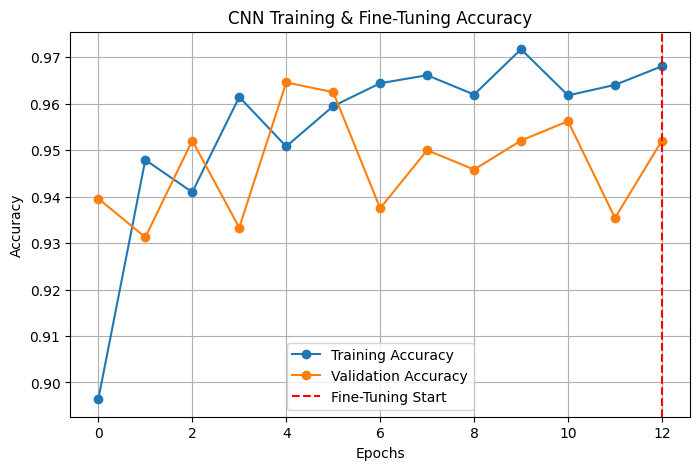

In [ ]:
# 1. Make sure matplotlib is imported
import matplotlib.pyplot as plt

# 2. Your function definition (keep it as is)
def plot_training_history(history, fine_tune_history=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    if fine_tune_history:
        acc += fine_tune_history.history['accuracy']
        val_acc += fine_tune_history.history['val_accuracy']

    plt.figure(figsize=(8, 5))
    plt.plot(acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')

    if fine_tune_history:
        # This draws the red line where fine-tuning started
        plt.axvline(x=len(history.history['accuracy'])-1, color='r', linestyle='--', label='Fine-Tuning Start')

    plt.title('CNN Training & Fine-Tuning Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# 3. THE FIX: Actually CALL the function without the '#'
# Ensure 'history' and 'fine_tune_history' exist from your training cell
plot_training_history(history, fine_tune_history)

# FINAL ML

In [ ]:
# Run this first!
test_datagen = ImageDataGenerator(preprocessing_function=apply_clahe)

# Define the generator globally
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [ ]:
# ==========================================
# PART 3.5: THE FAIR TEST (ML vs CNN)
# ==========================================
# RUN THIS ONLY AFTER THE CNN PART IS FINISHED

import numpy as np
from sklearn.metrics import accuracy_score, classification_report

print("Extracting features from the REAL Test Set (624 images) for ML evaluation...")

X_test_final = []
y_test_final = []

# 1. Reset the generator created in the CNN part
test_generator.reset()

# 2. Extract features using the 'base' model from your CNN code
for i in range(len(test_generator)):
    imgs, labels = next(test_generator)

    # We use 'base' here because that's how you defined it in Part 4 of your CNN code
    # We apply Global Average Pooling to get the 1024-dimension vector
    features = base.predict(imgs, verbose=0)
    avg_features = np.mean(features, axis=(1, 2))

    X_test_final.extend(avg_features)
    y_test_final.extend(labels)

X_test_final = np.array(X_test_final)
y_test_final = np.array(y_test_final)

# 3. Scale using the same scaler from your ML training
X_test_scaled = scaler.transform(X_test_final)

# 4. Predict using your best ML model (Logistic Regression)
best_ml_model = models["Logistic Regression"]
ml_test_preds = best_ml_model.predict(X_test_scaled)

print("\n" + "="*50)
print("FAIR TEST RESULT: LOGISTIC REGRESSION ON HARD TEST SET")
print("="*50)
print(f"Test Accuracy: {accuracy_score(y_test_final, ml_test_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_final, ml_test_preds, target_names=['NORMAL', 'PNEUMONIA']))

Extracting features from the REAL Test Set (624 images) for ML evaluation...

FAIR TEST RESULT: LOGISTIC REGRESSION ON HARD TEST SET
Test Accuracy: 0.6250

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step


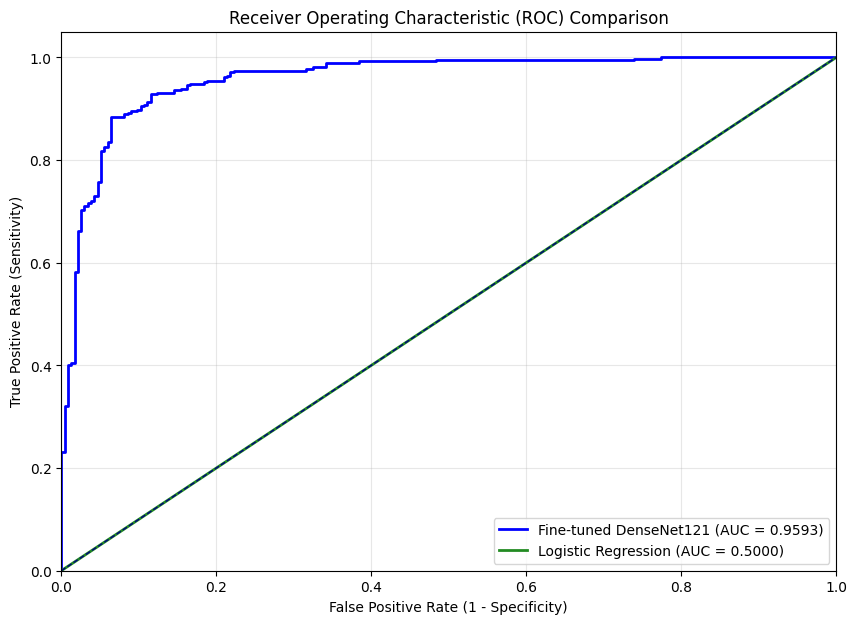

CNN AUC: 0.9593
ML AUC:  0.5000


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ==========================================
# FINAL COMPARISON: ML VS CNN
# ==========================================

# 1. Get probabilities for the CNN (DenseNet121)
# We use the test_generator and the 'model' variable from Part 3
cnn_probs = model.predict(test_generator).flatten()
fpr_cnn, tpr_cnn, _ = roc_curve(test_generator.classes, cnn_probs)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# 2. Get probabilities for the ML Model (Logistic Regression)
# We use the X_test_scaled and 'best_ml_model' from Part 3.5
# Note: make sure Part 3.5 has been run so these variables exist
ml_probs = best_ml_model.predict_proba(X_test_scaled)[:, 1]
fpr_ml, tpr_ml, _ = roc_curve(y_test_final, ml_probs)
roc_auc_ml = auc(fpr_ml, tpr_ml)

# 3. Plotting the Comparison
plt.figure(figsize=(10, 7))

# Plot CNN Line
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2,
         label=f'Fine-tuned DenseNet121 (AUC = {roc_auc_cnn:.4f})')

# Plot ML Line
plt.plot(fpr_ml, tpr_ml, color='forestgreen', lw=2,
         label=f'Logistic Regression (AUC = {roc_auc_ml:.4f})')

# Plot Baseline (Chance)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Comparison')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"CNN AUC: {roc_auc_cnn:.4f}")
print(f"ML AUC:  {roc_auc_ml:.4f}")

severity detection

In [ ]:
!pip install torchxrayvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 63.8 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import shutil
import torch
import torchxrayvision as xrv
import torchvision.transforms as transforms
import pandas as pd


In [ ]:
# Directory containing pneumonia-positive images
# (predicted by your best ML model)
input_dir = "/content/detected_pneumonia_cases"

# Output directory
output_dir = "/content/lung_severity_results"

for sub in ["masks", "opacity", "overlays"]:
    os.makedirs(os.path.join(output_dir, sub), exist_ok=True)


In [ ]:
print("Loading pretrained lung segmentation model...")

seg_model = xrv.baseline_models.chestx_det.PSPNet()
seg_model.eval()

# Required preprocessing for torchxrayvision
transform = transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(512),
])


Loading pretrained lung segmentation model...
If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/pspnet_chestxray_best_model_4.pth -O /root/.torchxrayvision/models_data/pspnet_chestxray_best_model_4.pth`
[██████████████████████████████████████████████████]


In [ ]:
def segment_lungs(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError("Could not read image")

    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Normalize as expected by model
    img = xrv.datasets.normalize(img_bgr, 255)
    img = np.mean(img, axis=2)   # convert to grayscale
    img = img[None, ...]         # add channel dimension

    img_tensor = transform(img)
    img_tensor = torch.from_numpy(img_tensor).unsqueeze(0)

    with torch.no_grad():
        output = seg_model(img_tensor)

    # Left lung = channel 4, Right lung = channel 5
    left_lung = output[0, 4].cpu().numpy()
    right_lung = output[0, 5].cpu().numpy()

    lung_prob = left_lung + right_lung
    lung_mask = (lung_prob > 0.5).astype(np.uint8) * 255

    lung_mask = cv2.resize(
        lung_mask,
        (gray.shape[1], gray.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )

    return rgb, gray, lung_mask


In [ ]:
def risk_level(severity_pct):
    if severity_pct < 25:
        return "Low"
    elif severity_pct < 50:
        return "Medium"
    else:
        return "High"


In [ ]:
records = []
processed = 0

print("\n--- Starting Lung Severity Analysis ---")

for img_name in sorted(os.listdir(input_dir)):
    img_path = os.path.join(input_dir, img_name)

    try:
        rgb, gray, lung_mask = segment_lungs(img_path)

        # Save lung mask
        cv2.imwrite(os.path.join(output_dir, "masks", img_name), lung_mask)

        # Extract lung region
        lung_region = cv2.bitwise_and(gray, gray, mask=lung_mask)

        # Opacity detection
        opacity = cv2.adaptiveThreshold(
            lung_region,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            71,
            8
        )

        opacity = cv2.bitwise_and(opacity, opacity, mask=lung_mask)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        opacity = cv2.morphologyEx(opacity, cv2.MORPH_OPEN, kernel)

        cv2.imwrite(os.path.join(output_dir, "opacity", img_name), opacity)

        # Severity calculation
        lung_pixels = np.count_nonzero(lung_mask)
        opacity_pixels = np.count_nonzero(opacity)

        severity_pct = (opacity_pixels / lung_pixels * 100) if lung_pixels > 0 else 0
        risk = risk_level(severity_pct)

        # Overlay visualization
        overlay = rgb.copy()
        overlay[opacity > 0] = [255, 0, 0]

        cv2.putText(
            overlay,
            f"{severity_pct:.1f}% | {risk}",
            (30, 60),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.6,
            (0, 255, 0),
            3
        )

        cv2.imwrite(
            os.path.join(output_dir, "overlays", img_name),
            cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
        )

        records.append({
            "Image": img_name,
            "Severity (%)": severity_pct,
            "Risk Level": risk
        })

        processed += 1
        if processed % 10 == 0:
            print(f"Processed {processed} images")

    except Exception as e:
        print(f"Error processing {img_name}: {e}")



--- Starting Lung Severity Analysis ---
Processed 10 images
Processed 20 images
Processed 30 images
Processed 40 images
Processed 50 images
Processed 60 images
Processed 70 images
Processed 80 images
Processed 90 images
Processed 100 images
Processed 110 images
Processed 120 images
Processed 130 images
Processed 140 images
Processed 150 images
Processed 160 images
Processed 170 images
Processed 180 images
Processed 190 images
Processed 200 images
Processed 210 images
Processed 220 images
Processed 230 images
Processed 240 images
Processed 250 images
